![Add a relevant banner image here](https://t4.ftcdn.net/jpg/04/86/66/75/360_F_486667590_RXONs4sn4K7OO7rtGYhN8aH3UnseCjTu.jpg)

# Bumps Ahead: A Data Analysis of Traffic Accidents and Road Safety

## Overview

This project looks at over 7 million traffic accidents across the United States to understand when and where crashes happen and how serious they are. Here are our key findings:

- Accidents are most common during weekday rush hours, but weekends and nighttime crashes tend to be more severe. 
- Poor weather conditions like low visibility, rain, and strong winds are linked to more dangerous accidents. 
- Certain road features such as junctions and rail crossings are tied to higher severity, while roundabouts and traffic signals are associated with safer outcomes. 

These findings can help the Department of Transportation focus on improving road design, responding to weather risks, and increasing safety efforts during the most dangerous times.

## Data Understanding

Text here

In [36]:
# Load relevant imports here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, chi2_contingency, chisquare
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import product



In [37]:
df = pd.read_csv('US_Accidents_March23.csv')


# Preview the first few rows of the dataset
print("First 5 rows:")
print(df.head())

# Get the shape of the dataset
print("\nDataset shape:")
print(df.shape)

# Get column data types and non-null counts
print("\nInfo:")
print(df.info())

# Get summary statistics for numerical columns
print("\nSummary statistics:")
print(df.describe())

# Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

# Get unique values in a few key columns (for context)
print("\nUnique states involved:")
print(df['State'].unique())

print("\nTop 10 cities with most accidents:")
print(df['City'].value_counts().head(10))

First 5 rows:
    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  False           Fa

The summarys stats give us a really good high-level view of the data. A couple of thoughts right off the bat:

1. The Start_Time and End_Time need reformmatted and then split. We'll want to be able to separately analyze times of day and dates independently. 
2. Getting the actual day of the week that the incidient took place will help us understand accident patterns throughout the week.
3. Columns like End_Lat, End_Lng, Precipitation(in), and Wind_Chill(F) have a lot of missing values. I'm hesitant to fully drop them, especially Precipitation(in) and Wind_Chill(F), just in case we want to look into weather impacts on accidents. I will drop End_Lat and End_Lng becuase there's so many nulls.
4. I'm going to add some binary columns for statistical analysis later:
    - Is_Weekend
    - Is_Rush_Hour
    - Low_Visibility
    - Has_Precipitation
    - High_Wind
    - Below_Freezing
    - Severe_Weather_Condition
5. The Twighlight columns are a little confusing. Here's what I found to define them:
    - Civil Twilight
        - Definition: The period when the sun is 0–6° below the horizon.
        - Real-World Meaning: There’s still enough natural light for most outdoor activities without artificial lighting.
        - Driver Implication: Visibility is generally decent; streetlights may or may not be needed.
        - Often used by: Aviation and civil authorities to define “safe to drive without headlights.”
    - Nautical Twilight
        - Definition: The sun is 6–12° below the horizon.
        - Real-World Meaning: It's darker — the horizon is still visible, but you typically need artificial lighting.
        - Driver Implication: Reduced visibility; headlights are important.
    - Astronomical Twilight
        - Definition: The sun is 12–18° below the horizon.
        - Real-World Meaning: It's basically dark, though some light may still be detected under ideal conditions.
        - Driver Implication: Night driving conditions — full headlights required


## Data Preparation

In [38]:
# Convert data/time formatting
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce', format='mixed')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce', format='mixed')

# Create new columns
df['Start_Date'] = df['Start_Time'].dt.date
df['Start_Hour'] = df['Start_Time'].dt.hour 
df['Start_Weekday'] = df['Start_Time'].dt.day_name()
df['Start_Month'] = df['Start_Time'].dt.month_name()

df['End_Date'] = df['End_Time'].dt.date
df['End_Hour'] = df['End_Time'].dt.hour 
df['End_Weekday'] = df['End_Time'].dt.day_name()
df['End_Month'] = df['End_Time'].dt.month_name()

print(df[['Start_Time', 'Start_Date', 'Start_Hour', 'Start_Weekday', 'Start_Month']].head())
print(df[['Start_Date', 'Start_Hour', 'Start_Weekday', 'Start_Month']].dtypes)


           Start_Time  Start_Date  Start_Hour Start_Weekday Start_Month
0 2016-02-08 05:46:00  2016-02-08           5        Monday    February
1 2016-02-08 06:07:59  2016-02-08           6        Monday    February
2 2016-02-08 06:49:27  2016-02-08           6        Monday    February
3 2016-02-08 07:23:34  2016-02-08           7        Monday    February
4 2016-02-08 07:39:07  2016-02-08           7        Monday    February
Start_Date       object
Start_Hour        int32
Start_Weekday    object
Start_Month      object
dtype: object


In [39]:
# Drop End_Lat and End_Lng
df = df.drop(columns=['End_Lat', 'End_Lng'])

In [40]:
# Add binary columns for weekend and rush hour
df['Is_Weekend'] = df['Start_Weekday'].isin(['Saturday', 'Sunday'])
df['Is_Rush_Hour'] = (
    (~df['Is_Weekend']) & #filtering out weekend accidents
    (df['Start_Hour'].isin([7, 8, 16, 17, 18]))
)

print(df[['Is_Weekend', 'Is_Rush_Hour']].head())

   Is_Weekend  Is_Rush_Hour
0       False         False
1       False         False
2       False         False
3       False          True
4       False          True


In [41]:
# Add binary columns for environmental factors
df['Low_Visibility'] = df['Visibility(mi)'] < 1.0
df['Has_Precipitation'] = df['Precipitation(in)'] > 0
df['High_Wind'] = df['Wind_Speed(mph)'] > 20 
df['Below_Freezing'] = df['Temperature(F)'] < 32
severe_weather = ['Fog', 'Snow', 'Thunderstorm', 'Ice', 'Hail', 'Sleet', 'Storm']
df['Severe_Weather_Condition'] = df['Weather_Condition'].str.contains('|'.join(severe_weather), na=False)

## Business Insight & Recommendation 1

Spatial and Temporal Patterns: Consider examining when and where accidents most frequently occur. You might explore patterns by time of day, day of week, season, and geographic location. This type of analysis could potentially reveal critical hotspots and time periods requiring intervention.

### Rush Hour

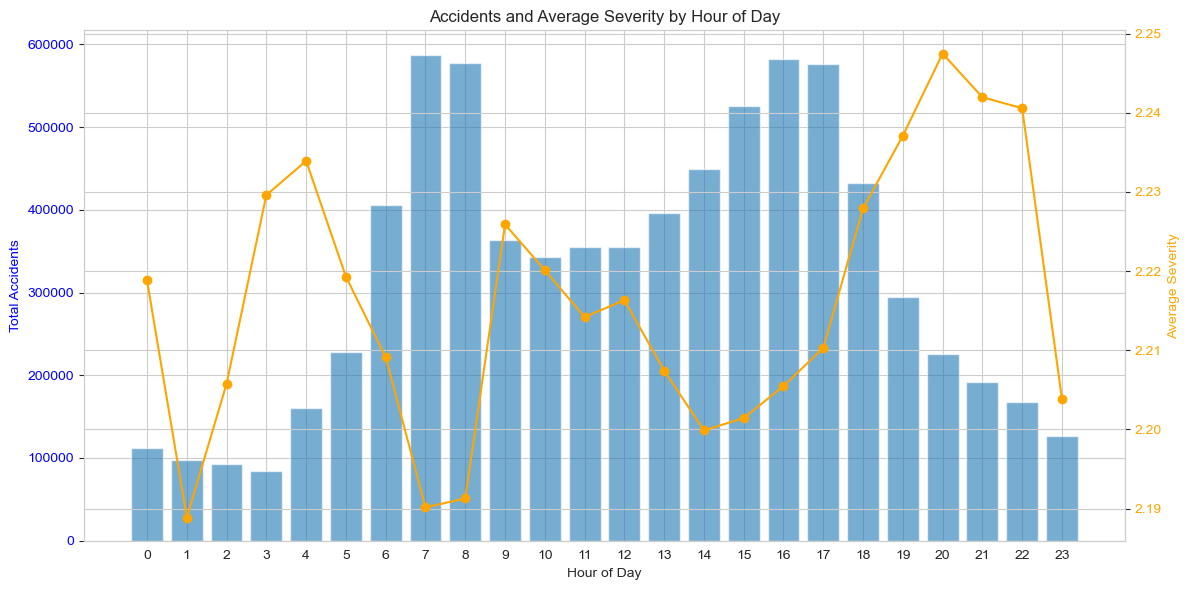

In [42]:
# Accident severity by hour
# Total accidents per hour
accidents_per_hour = df['Start_Hour'].value_counts().sort_index()

# Average severity per hour
avg_severity_per_hour = df.groupby('Start_Hour')['Severity'].mean()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot: total accidents
ax1.bar(accidents_per_hour.index, accidents_per_hour.values, alpha=0.6)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Total Accidents', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0, 24))

# Line plot: average severity
ax2 = ax1.twinx()
ax2.plot(avg_severity_per_hour.index, avg_severity_per_hour.values, color='orange', marker='o')
ax2.set_ylabel('Average Severity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Accidents and Average Severity by Hour of Day')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

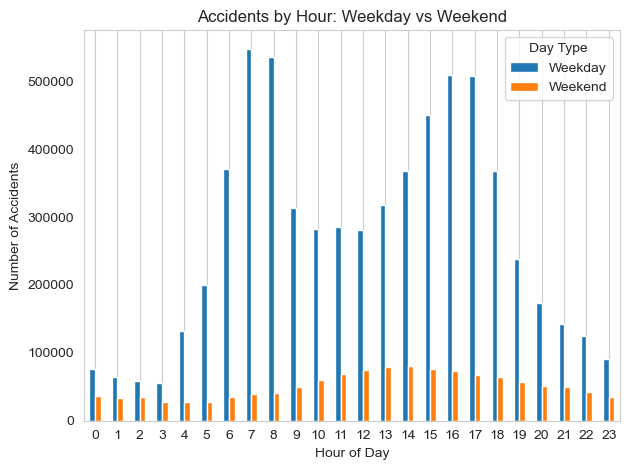

In [43]:
# Weekday vs Weekend split
# Group by hour and weekend flag
hourly_weekend = df.groupby(['Start_Hour', 'Is_Weekend']).size().unstack()

# Rename columns for clarity
hourly_weekend.columns = ['Weekday', 'Weekend']

# Plot weekday vs weekend accident counts by hour
plt.figure(figsize=(12, 6))
hourly_weekend.plot(kind='bar', stacked=False)
plt.title('Accidents by Hour: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.legend(title='Day Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [44]:
# Two-sample t-test comparing mean severity of rush hour vs non rush hour

# Separate severity by rush hour flag
rush_hour_severity = df[df['Is_Rush_Hour'] == True]['Severity'].dropna()
non_rush_hour_severity = df[df['Is_Rush_Hour'] == False]['Severity'].dropna()

# Run independent t-test
t_stat, p_val = ttest_ind(rush_hour_severity, non_rush_hour_severity, equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Chi-squared 
# Create a 2x2 contingency table
table = pd.crosstab(df['Is_Rush_Hour'], df['Severity'])

# Run chi-squared test comparing accident frequency
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi-squared: {chi2:.4f}")
print(f"p-value: {p:.6f}")

t-statistic: -61.5643
p-value: 0.000000
Chi-squared: 17155.2785
p-value: 0.000000


- Strong t-test p-value indicates statistically significance difference in average accident severity between rush hour and non-rush hour. 
- Negative t-stat means rush hour accidents have a lower average severity compared to non-rush hour.
- Rush hour accidents are frequent, but they're often less severe, likely due to slower traffic.
- Strong chi-squared p-value again, indicating that severity is not independent of rush hour.

##### Key takeaways from rush hour tests:

Accidents during rush hours occur more frequently but tend to be less severe, possibly due to lower average vehicle speeds and more congestion. Statistical testing confirms this relationship is highly significant (t-test p < 0.000001, chi-squared p < 0.000001). This insight supports focusing DOT efforts on traffic flow optimization and fender-bender prevention during rush hours, while prioritizing high-severity risk mitigation during off-peak, late-night, or rural hours.

### Weekday vs Weekend

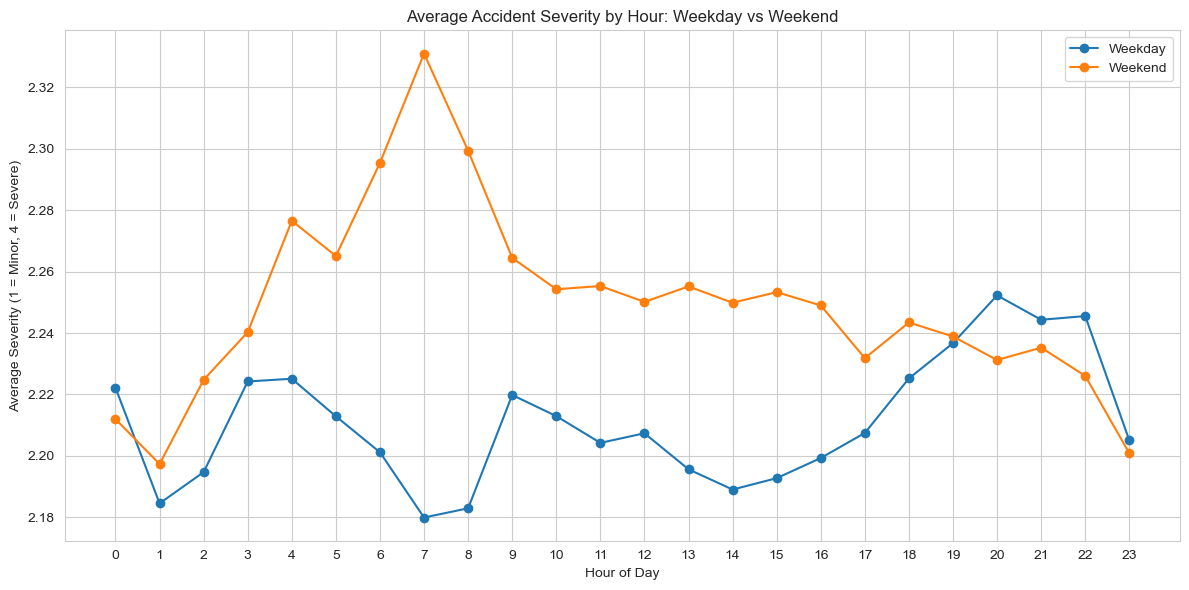

In [45]:
# Weekday vs Weekend Severity
# Group and calculate mean severity
severity_split = df.groupby(['Start_Hour', 'Is_Weekend'])['Severity'].mean().unstack()
severity_split.columns = ['Weekday', 'Weekend']  # Rename for clarity

# Plot
plt.figure(figsize=(12, 6))
severity_split['Weekday'].plot(label='Weekday', marker='o')
severity_split['Weekend'].plot(label='Weekend', marker='o')

plt.title('Average Accident Severity by Hour: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Severity (1 = Minor, 4 = Severe)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Separate severity values
weekend_severity = df[df['Is_Weekend'] == True]['Severity'].dropna()
weekday_severity = df[df['Is_Weekend'] == False]['Severity'].dropna()

# Run t-test
t_stat, p_val = ttest_ind(weekend_severity, weekday_severity, equal_var=False)

print(f"T-test for Is_Weekend:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Create a 2x2+ contingency table
weekend_table = pd.crosstab(df['Is_Weekend'], df['Severity'])

# Run chi-squared test
chi2, p, dof, expected = chi2_contingency(weekend_table)

print(f"\nChi-Squared Test for Is_Weekend:")
print(f"Chi-squared: {chi2:.4f}")
print(f"p-value: {p:.6f}")

T-test for Is_Weekend:
t-statistic: 86.8104
p-value: 0.000000

Chi-Squared Test for Is_Weekend:
Chi-squared: 11643.6643
p-value: 0.000000


- T-test shows the average severity on weekends is statistically different from weekdays.
- T-stat is positive, so weekend accidents are more severe on average than weekday ones.
- Chi-squared shows weekends have a different mix of severity levels compared to weekdays.

##### Key takeaways from weekend/weekday tests:

Weekend accidents are less frequent overall, but statistically more severe, likely due to higher speeds, longer trips, impaired driving, or reduced enforcement coverage. This suggests the DOT should focus more attention on late-night weekend driving safety, such as targeted DUI campaigns, speed enforcement, and public awareness around high-risk times.

### Day of the Week

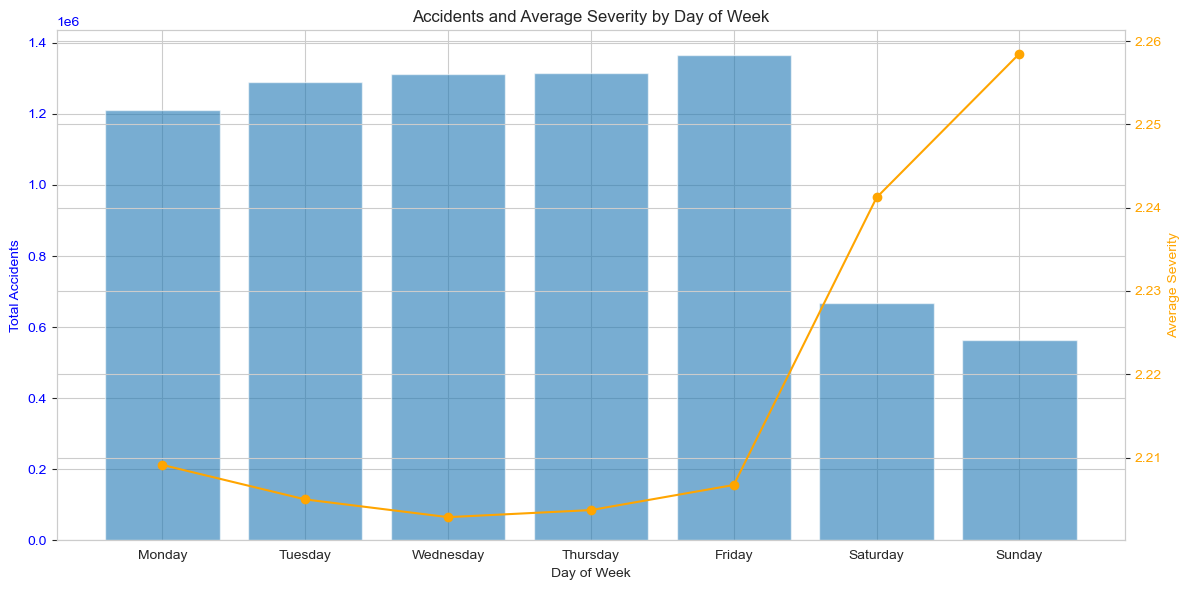

In [47]:
# Accident severity by day
# Define correct weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex to correct order
accidents_per_day = df['Start_Weekday'].value_counts().reindex(weekday_order)
avg_severity_per_day = df.groupby('Start_Weekday')['Severity'].mean().reindex(weekday_order)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot: total accidents
ax1.bar(accidents_per_day.index, accidents_per_day.values, alpha=0.6)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Total Accidents', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line plot: average severity
ax2 = ax1.twinx()
ax2.plot(avg_severity_per_day.index, avg_severity_per_day.values, color='orange', marker='o')
ax2.set_ylabel('Average Severity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Accidents and Average Severity by Day of Week')
plt.xticks(rotation=45)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [48]:
# One-way ANOVA: Do accident severities differ by day of the week?
# Group severity by weekday
weekday_severity_groups = [df[df['Start_Weekday'] == day]['Severity'].dropna() for day in weekday_order]

# Run ANOVA
f_stat, p_val = f_oneway(*weekday_severity_groups)

print("ANOVA: Severity by Day of Week")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Chi-Squared: Do accident counts differ by day of the week?
# Accident counts by weekday (ordered)
weekday_counts = df['Start_Weekday'].value_counts().reindex(weekday_order)

# Expected count if evenly distributed
expected = [weekday_counts.sum() / 7] * 7

# Chi-squared test
chi2_stat, p_val = chisquare(f_obs=weekday_counts, f_exp=expected)

print("\nChi-Squared Test: Accident Counts by Day of Week")
print(f"Chi-squared: {chi2_stat:.4f}")
print(f"p-value: {p_val:.6f}")

ANOVA: Severity by Day of Week
F-statistic: 1473.9863
p-value: 0.000000

Chi-Squared Test: Accident Counts by Day of Week
Chi-squared: 621532.0132
p-value: 0.000000


- ANOVA test shows there is a statistically significant difference in average accident severity across the 7 days of the week.
- Chi-Squared shows accidents are not evenly distributed across the week.
- Let's run the post hoc to see which days have higher severity (I think we know where this is going)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
  Friday    Monday   0.0024 0.0014  0.0006  0.0042   True
  Friday  Saturday   0.0345    0.0  0.0324  0.0367   True
  Friday    Sunday   0.0518    0.0  0.0495  0.0541   True
  Friday  Thursday   -0.003    0.0 -0.0048 -0.0013   True
  Friday   Tuesday  -0.0017 0.0575 -0.0035     0.0  False
  Friday Wednesday  -0.0039    0.0 -0.0056 -0.0021   True
  Monday  Saturday   0.0321    0.0  0.0299  0.0343   True
  Monday    Sunday   0.0494    0.0  0.0471  0.0517   True
  Monday  Thursday  -0.0054    0.0 -0.0072 -0.0036   True
  Monday   Tuesday  -0.0041    0.0  -0.006 -0.0023   True
  Monday Wednesday  -0.0063    0.0 -0.0081 -0.0045   True
Saturday    Sunday   0.0173    0.0  0.0147  0.0199   True
Saturday  Thursday  -0.0375    0.0 -0.0397 -0.0354   True
Saturday   Tuesday  -0.0363    0.0 -0.0384 -0.0341   True
Saturday Wedne

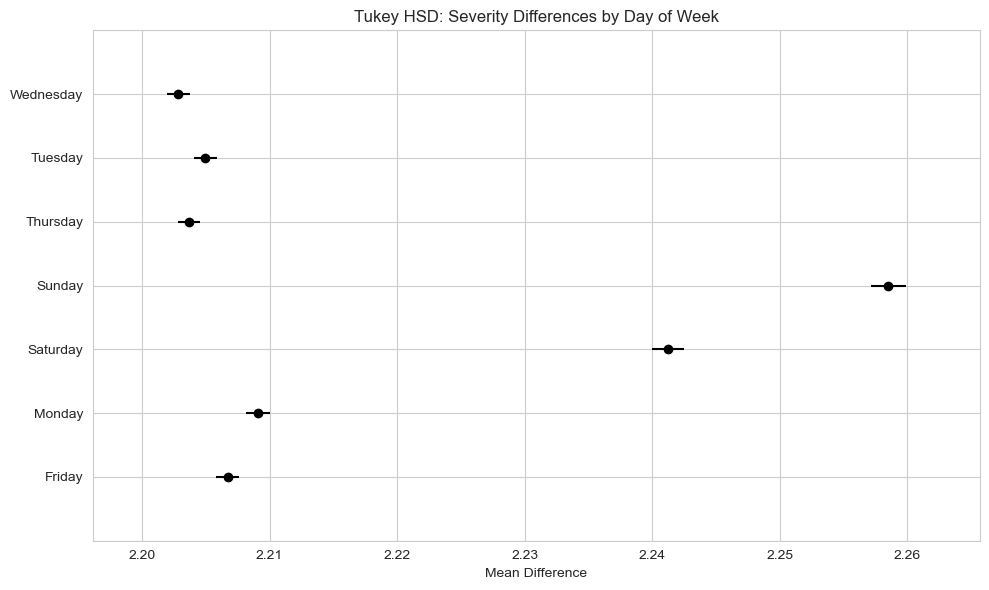

In [49]:
# Tukey HSD
# Make sure the weekdays are ordered consistently
tukey_data = df[['Start_Weekday', 'Severity']].dropna()

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=tukey_data['Severity'],
                          groups=tukey_data['Start_Weekday'],
                          alpha=0.05)

# Print the results
print(tukey.summary())

# Plot visualization
tukey.plot_simultaneous(figsize=(10, 6))
plt.title('Tukey HSD: Severity Differences by Day of Week')
plt.xlabel('Mean Difference')
plt.grid(True)
plt.tight_layout()
plt.show()

- Confirmed, Saturday and Sunday have the highest average accident severity — significantly higher than any weekday.
- Most weekday vs weekday comparisons are either not significant or show small differences
    - Wednesday vs Tuesday: meandiff = -0.0021
    - Monday vs Wednesday: meandiff = -0.0063

##### Key takeaways from day of week tests:
 
Both the frequency and severity of accidents vary by day of the week. Weekdays may have more crashes (volume-driven), while weekends have fewer but more severe crashes (risk-driven). DOT should tailor its safety strategies:

Weekdays: Focus on congestion mitigation, signal timing, and enforcement in urban corridors.

Weekends: Emphasize nighttime patrols, impaired driving prevention, and rural safety measures.

#### Region

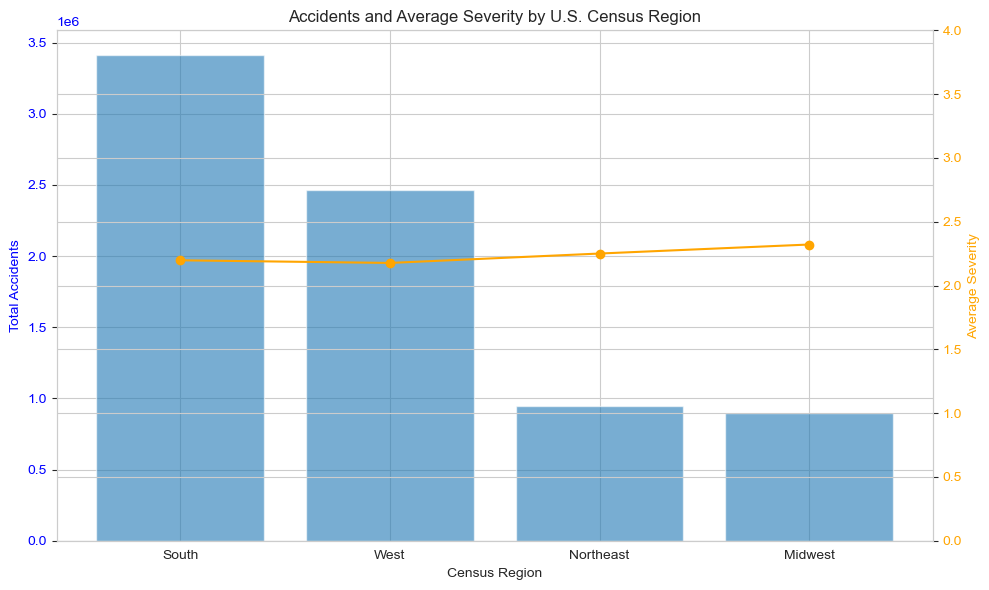

In [50]:
# Let's bundle by Census region
# Define state-to-region mapping
region_map = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
    'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
    'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest',
    'ND': 'Midwest', 'SD': 'Midwest',
    
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South',
    'SC': 'South', 'VA': 'South', 'DC': 'South', 'WV': 'South', 'AL': 'South',
    'KY': 'South', 'MS': 'South', 'TN': 'South', 'AR': 'South', 'LA': 'South',
    'OK': 'South', 'TX': 'South',
    
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West',
    'NM': 'West', 'UT': 'West', 'WY': 'West', 'AK': 'West', 'CA': 'West',
    'HI': 'West', 'OR': 'West', 'WA': 'West'
}

# Add 'Region' column based on State
df['Region'] = df['State'].map(region_map)

# Total accidents per region
accidents_by_region = df['Region'].value_counts().sort_values(ascending=False)

# Average severity per region
severity_by_region = df.groupby('Region')['Severity'].mean().loc[accidents_by_region.index]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar: accident count
ax1.bar(accidents_by_region.index, accidents_by_region.values, alpha=0.6)
ax1.set_xlabel('Census Region')
ax1.set_ylabel('Total Accidents', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line: average severity
ax2 = ax1.twinx()
ax2.plot(severity_by_region.index, severity_by_region.values, color='orange', marker='o')
ax2.set_ylabel('Average Severity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 4)

plt.title('Accidents and Average Severity by U.S. Census Region')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

ANOVA: Severity by Region
F-statistic: 22531.2757
p-value: 0.000000

Chi-Squared Test: Accident Frequency by Region
Chi-squared: 2335567.3922
p-value: 0.000000
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
  Midwest Northeast  -0.0707   0.0 -0.0725 -0.0689   True
  Midwest     South  -0.1237   0.0 -0.1252 -0.1222   True
  Midwest      West  -0.1445   0.0  -0.146 -0.1429   True
Northeast     South   -0.053   0.0 -0.0545 -0.0516   True
Northeast      West  -0.0737   0.0 -0.0753 -0.0722   True
    South      West  -0.0207   0.0 -0.0218 -0.0197   True
---------------------------------------------------------


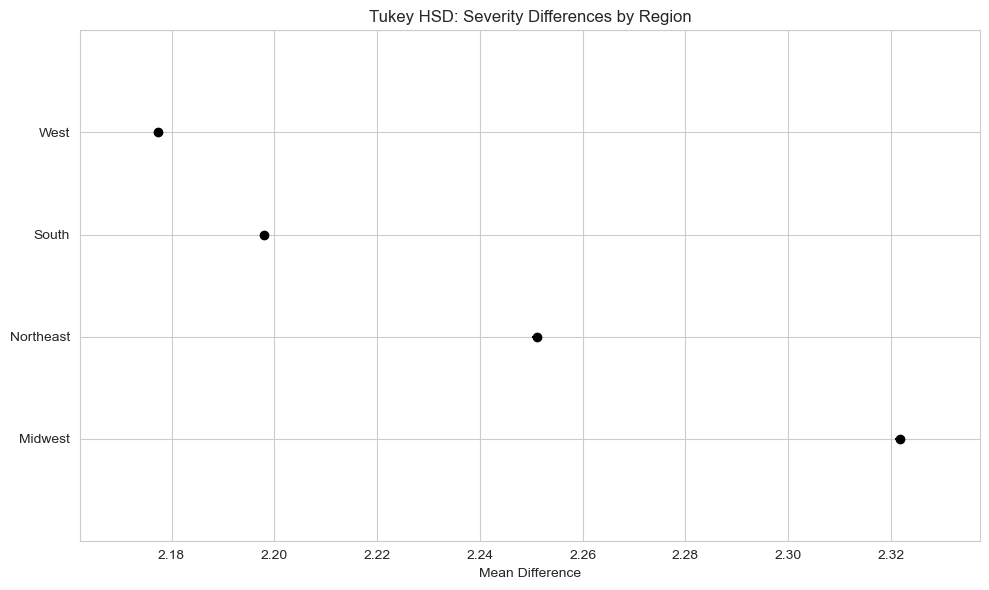

In [51]:
# Census Region analysis

# ANOVA: do average accident severities differ by region?
# Create groups for severity by region
region_severity_groups = [df[df['Region'] == region]['Severity'].dropna() for region in ['Northeast', 'Midwest', 'South', 'West']]

# Run ANOVA
f_stat, p_val = f_oneway(*region_severity_groups)

print("ANOVA: Severity by Region")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Chi-squared: are accident frequencies uneven across regions?
# Accident count by region
region_counts = df['Region'].value_counts().reindex(['Northeast', 'Midwest', 'South', 'West'])

# Expected count if even across 4 regions
expected_counts = [region_counts.sum() / 4] * 4

# Chi-squared test
chi2_stat, p_val = chisquare(f_obs=region_counts, f_exp=expected_counts)

print("\nChi-Squared Test: Accident Frequency by Region")
print(f"Chi-squared: {chi2_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Tukey HSD post hoc test
# Drop NAs just in case
tukey_data = df[['Region', 'Severity']].dropna()

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=tukey_data['Severity'],
                          groups=tukey_data['Region'],
                          alpha=0.05)

# Print results
print(tukey.summary())

# Plot
tukey.plot_simultaneous(figsize=(10, 6))
plt.title('Tukey HSD: Severity Differences by Region')
plt.xlabel('Mean Difference')
plt.grid(True)
plt.tight_layout()
plt.show()

- ANOVA (F = 22,531.28) — Mean severity varies significantly by region.
- Chi-Squared (χ² = 2,335,567.39) — Accident counts are far from evenly distributed across regions.
- Post hoc
    - West region has the highest average accident severity.
    - Midwest has the lowest severity by a meaningful margin.
    - Even though all differences are statistically significant, the most practically meaningful gaps are between:
        - Midwest vs West (~0.14 severity points)
        - Midwest vs South
    - The South has the most accidents overall (from Chi-squared), but not the most severe.

##### Key takeaways from day of week tests:

Accident severity varies substantially by region. The West stands out with the highest average severity, while the Midwest has the lowest. This may be due to longer rural stretches, higher average speeds, or different emergency response times. Regional safety strategies should be tailored — focusing on crash mitigation and response in the West, and volume management in the South.

#### State

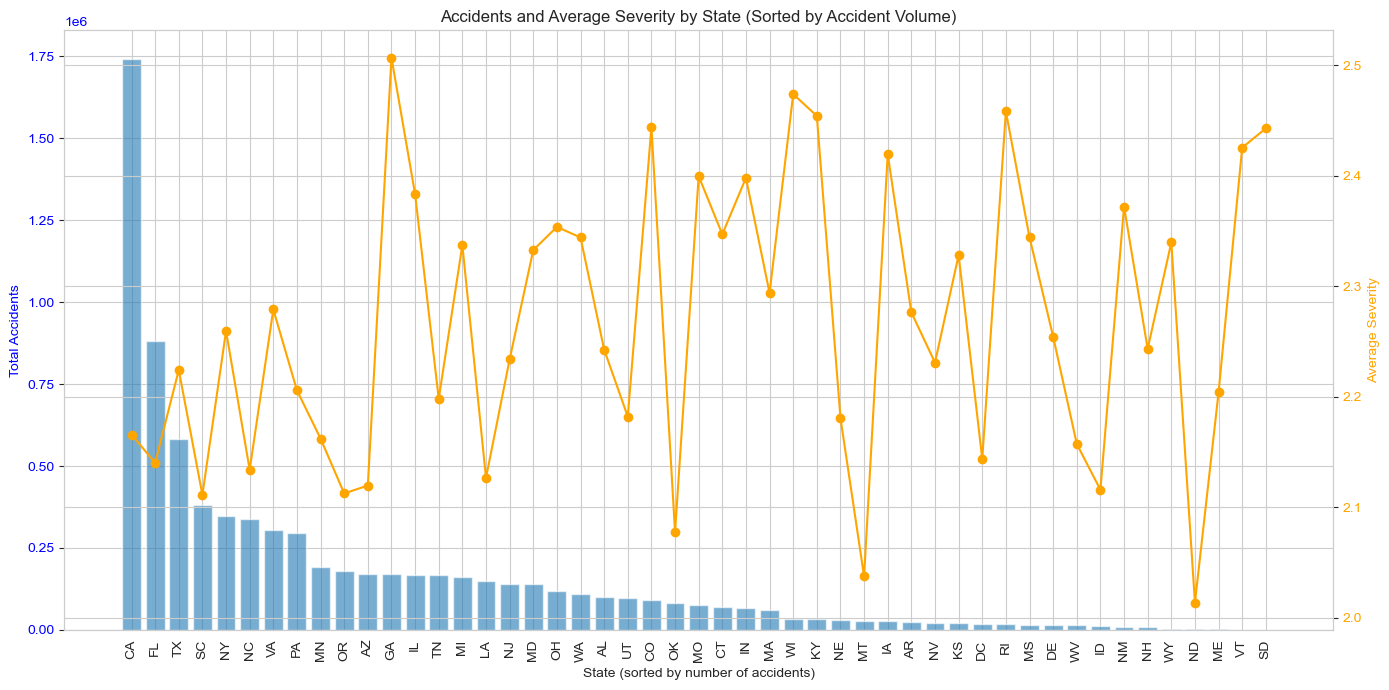

In [52]:
# Accidents and severity by state
# Total accidents per state
accidents_by_state = df['State'].value_counts().sort_values(ascending=False)

# Average severity per state
severity_by_state = df.groupby('State')['Severity'].mean().loc[accidents_by_state.index]

# Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot: total accidents
ax1.bar(accidents_by_state.index, accidents_by_state.values, alpha=0.6)
ax1.set_xlabel('State (sorted by number of accidents)')
ax1.set_ylabel('Total Accidents', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(accidents_by_state.index)))
ax1.set_xticklabels(accidents_by_state.index, rotation=90)

# Line plot: average severity
ax2 = ax1.twinx()
ax2.plot(severity_by_state.index, severity_by_state.values, color='orange', marker='o')
ax2.set_ylabel('Average Severity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Accidents and Average Severity by State (Sorted by Accident Volume)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

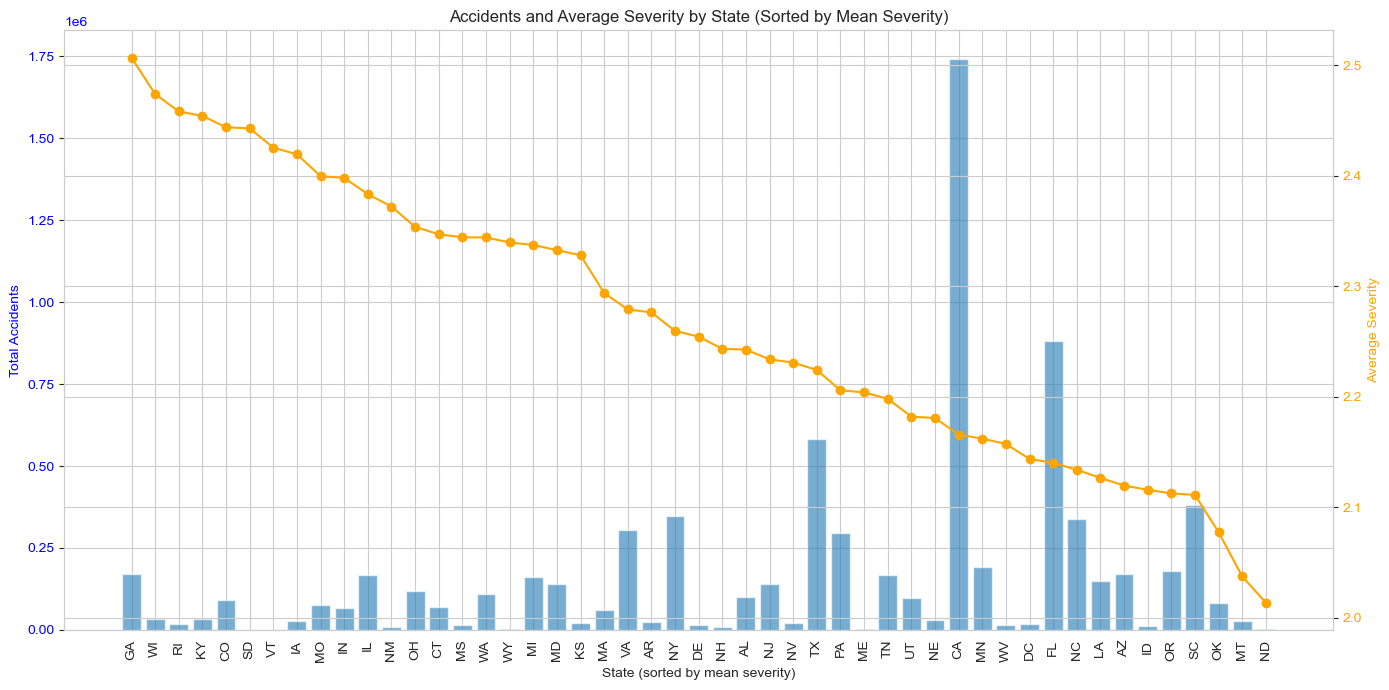

In [53]:
# Average severity per state
severity_by_state = df.groupby('State')['Severity'].mean().sort_values(ascending=False)

# Total accidents per state (reindexed to match sorted severity)
accidents_by_state = df['State'].value_counts().reindex(severity_by_state.index)

# Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot: total accidents
ax1.bar(severity_by_state.index, accidents_by_state.values, alpha=0.6)
ax1.set_xlabel('State (sorted by mean severity)')
ax1.set_ylabel('Total Accidents', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(severity_by_state.index)))
ax1.set_xticklabels(severity_by_state.index, rotation=90)

# Line plot: average severity
ax2 = ax1.twinx()
ax2.plot(severity_by_state.index, severity_by_state.values, color='orange', marker='o')
ax2.set_ylabel('Average Severity', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Accidents and Average Severity by State (Sorted by Mean Severity)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


ANOVA: Severity by State
F-statistic: 6574.4562
p-value: 0.000000

Chi-Squared Test: Accident Frequency by State
Chi-squared: 24404686.0532
p-value: 0.000000

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AL     AR   0.0337    0.0  0.0197  0.0476   True
    AL     AZ  -0.1231    0.0 -0.1307 -0.1155   True
    AL     CA  -0.0769    0.0 -0.0831 -0.0708   True
    AL     CO   0.2013    0.0  0.1926    0.21   True
    AL     CT   0.1044    0.0  0.0951  0.1137   True
    AL     DC   -0.099    0.0 -0.1142 -0.0838   True
    AL     DE   0.0117 0.8392 -0.0054  0.0288  False
    AL     FL  -0.1026    0.0 -0.1089 -0.0963   True
    AL     GA   0.2643    0.0  0.2567  0.2719   True
    AL     IA   0.1768    0.0  0.1636    0.19   True
    AL     ID   -0.127    0.0 -0.1458 -0.1081   True
    AL     IL   0.1407    0.0  0.1331  0.1482   True
    AL     IN   0.1554    0.0   0.146  0.1649 

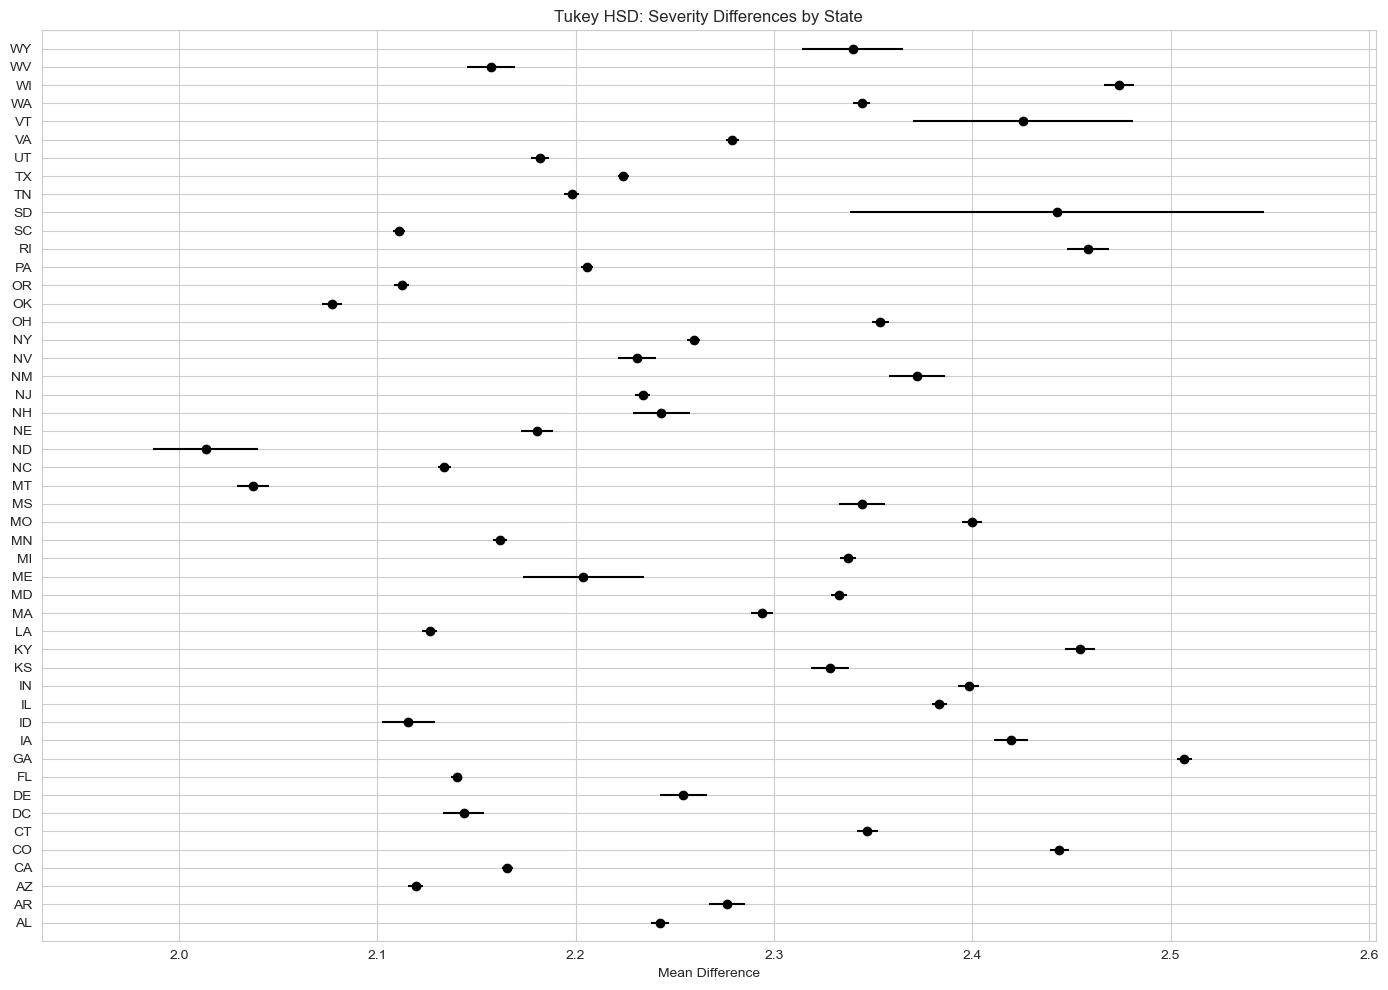

In [54]:
# ANOVA
# Create severity groups by state
state_severity_groups = [group['Severity'].dropna() for _, group in df.groupby('State')]

# Run ANOVA
f_stat, p_val = f_oneway(*state_severity_groups)

print("ANOVA: Severity by State")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Chi-squared Test
# Get counts of accidents per state
state_counts = df['State'].value_counts()

# Expected count if accidents were evenly distributed
expected_counts = [state_counts.sum() / len(state_counts)] * len(state_counts)

# Run Chi-squared test
chi2_stat, p_val = chisquare(f_obs=state_counts, f_exp=expected_counts)

print("\nChi-Squared Test: Accident Frequency by State")
print(f"Chi-squared: {chi2_stat:.4f}")
print(f"p-value: {p_val:.6f}\n")

# Tukey HSD

# Filter and prepare data
tukey_data = df[['State', 'Severity']].dropna()

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=tukey_data['Severity'],
                          groups=tukey_data['State'],
                          alpha=0.05)

# Show results
print(tukey.summary())

# Plot
tukey.plot_simultaneous(figsize=(14, 10))
plt.title('Tukey HSD: Severity Differences by State')
plt.xlabel('Mean Difference')
plt.tight_layout()
plt.grid(True)
plt.show()

- There are significant differences in average accident severity across states.
- Accident frequency is not evenly distributed across states.
- Post hoc results are...a lot. Let's look at the top 10 and bottom 10 states by severity

In [55]:
# Group by state and calculate mean severity
state_severity_means = df.groupby('State')['Severity'].mean().sort_values()

# Top 10 states with lowest average severity
lowest_severity_states = state_severity_means.head(10)

# Top 10 states with highest average severity
highest_severity_states = state_severity_means.tail(10)

# Optional: print or display
print("Top 10 States with Lowest Average Severity:")
print(lowest_severity_states)

print("\nTop 10 States with Highest Average Severity:")
print(highest_severity_states)

Top 10 States with Lowest Average Severity:
State
ND    2.013479
MT    2.037233
OK    2.077313
SC    2.111055
OR    2.112407
ID    2.115682
AZ    2.119536
LA    2.126459
NC    2.133824
FL    2.140060
Name: Severity, dtype: float64

Top 10 States with Highest Average Severity:
State
IN    2.398072
MO    2.399609
IA    2.419432
VT    2.425486
SD    2.442907
CO    2.443902
KY    2.454176
RI    2.458252
WI    2.473939
GA    2.506931
Name: Severity, dtype: float64


##### Key takeways for State:

Not all accidents are equal. While some states have more crashes overall, others have disproportionately dangerous crashes. DOT should focus on severity reduction in states like Georgia, Wisconsin, and Kentucky, while learning from low-severity leaders like North Dakota and Montana. Nighttime safety interventions and regionally tailored infrastructure improvements are key levers.

#### Astronomical Night (headlights required)

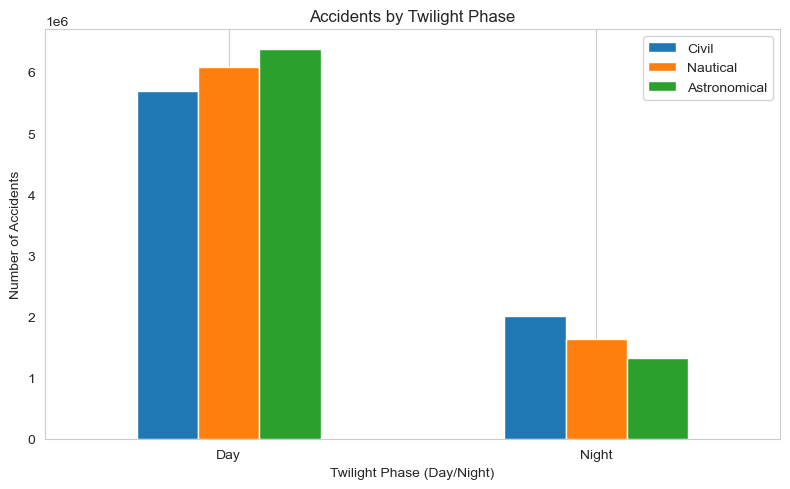

In [56]:
# Compare accidents at twilight phases
# Combine all three twilight phase counts
twilight_summary = {
    'Civil': df['Civil_Twilight'].value_counts(),
    'Nautical': df['Nautical_Twilight'].value_counts(),
    'Astronomical': df['Astronomical_Twilight'].value_counts()
}

# Convert to DataFrame
twilight_df = pd.DataFrame(twilight_summary)

# Plot all three twilight phase comparisons
twilight_df.plot(kind='bar', figsize=(8, 5))
plt.title('Accidents by Twilight Phase')
plt.xlabel('Twilight Phase (Day/Night)')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [57]:
# T-test
# Split severity by twilight phase
night_severity = df[df['Astronomical_Twilight'] == 'Night']['Severity'].dropna()
day_severity = df[df['Astronomical_Twilight'] == 'Day']['Severity'].dropna()

# Run t-test
t_stat, p_val = ttest_ind(night_severity, day_severity, equal_var=False)

print("\nT-Test: Severity During Astronomical Twilight")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.6f}")

# Chi-squared
from scipy.stats import chi2_contingency

# Count of accidents by Astronomical_Twilight
astro_counts = df['Astronomical_Twilight'].value_counts()

# Chi-squared test
chi2, p_val, _, _ = chi2_contingency([astro_counts])

print("Chi-Squared Test: Accident Frequency by Astronomical Twilight")
print(f"Chi-squared: {chi2:.4f}")
print(f"p-value: {p_val:.6f}")



T-Test: Severity During Astronomical Twilight
t-statistic: 17.4803
p-value: 0.000000
Chi-Squared Test: Accident Frequency by Astronomical Twilight
Chi-squared: 0.0000
p-value: 1.000000


- T-test: Accidents that happen during Astronomical Twilight (Night) are significantly more severe on average than those during the Day.
- Chi-squared: There is no statistically significant difference in the number of accidents during Astronomical Day vs. Night.

##### Key takeaways for Astronomical Night

While accidents are evenly split between day and night, those occurring during the darkest hours of the night are statistically more severe. Investments in nighttime road safety, like lighting, reflectors, or better signage, could have an outsized impact on reducing injury severity.

## Business Insight/Recommendation 2

Environmental Factors: You could investigate how weather conditions correlate with accident rates. Consider analyzing how visibility, precipitation, temperature, and other environmental variables might affect driver behavior and road conditions.

### Data Exploration

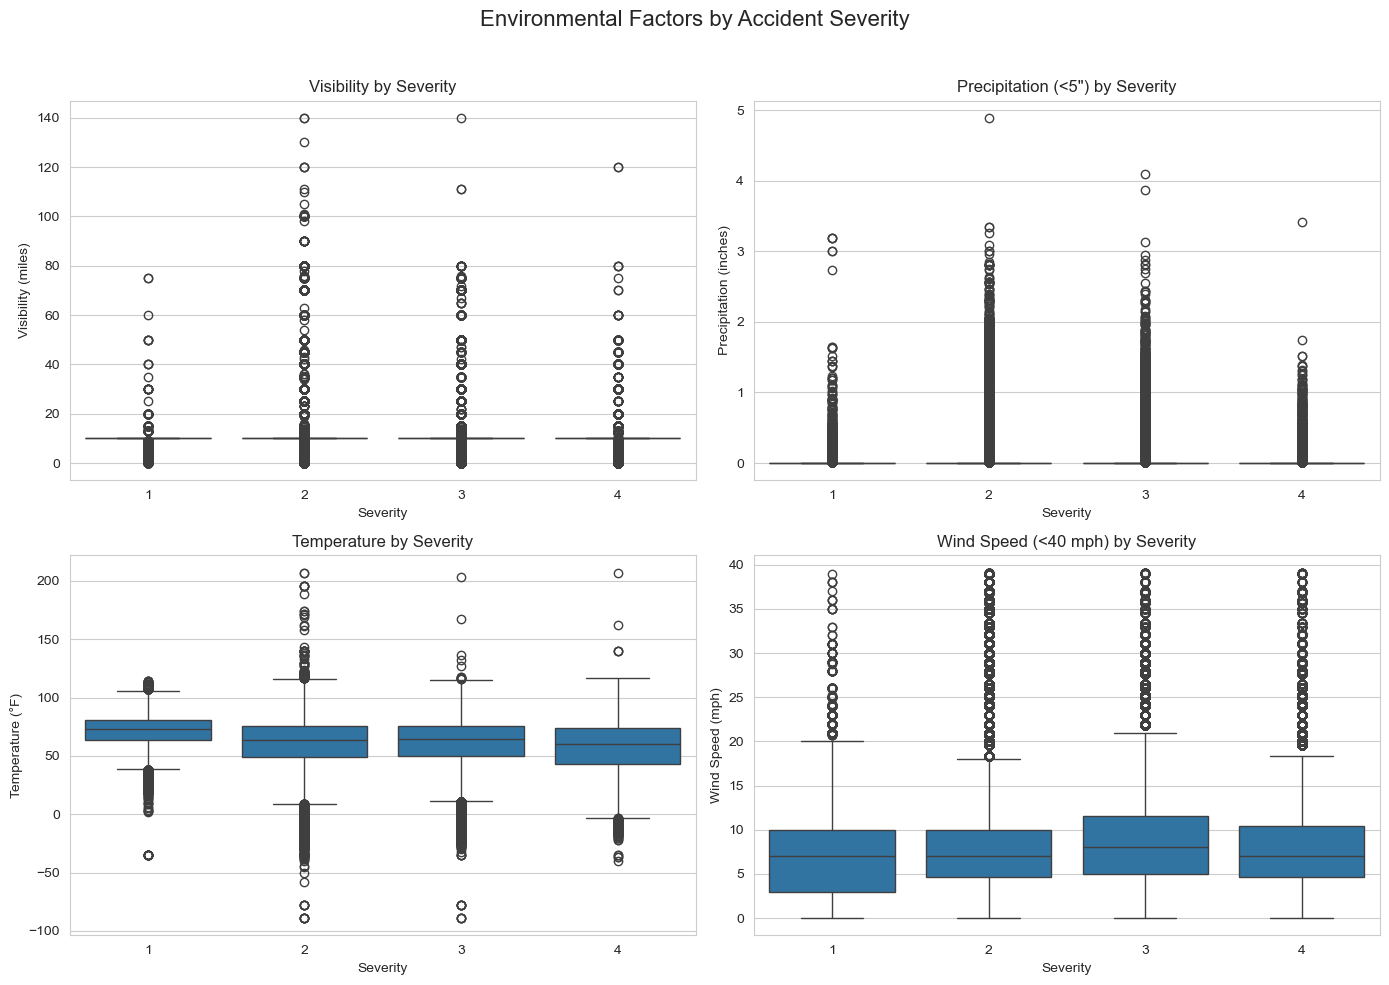

In [58]:
# Explore continuous environmental factors by severity

# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.suptitle('Environmental Factors by Accident Severity', fontsize=16)

# Plot 1: Visibility
sns.boxplot(ax=axes[0, 0], x='Severity', y='Visibility(mi)', data=df)
axes[0, 0].set_title('Visibility by Severity')
axes[0, 0].set_ylabel('Visibility (miles)')

# Plot 2: Precipitation (limit extreme outliers)
sns.boxplot(ax=axes[0, 1], x='Severity', y='Precipitation(in)', data=df[df['Precipitation(in)'] < 5])
axes[0, 1].set_title('Precipitation (<5") by Severity')
axes[0, 1].set_ylabel('Precipitation (inches)')

# Plot 3: Temperature
sns.boxplot(ax=axes[1, 0], x='Severity', y='Temperature(F)', data=df)
axes[1, 0].set_title('Temperature by Severity')
axes[1, 0].set_ylabel('Temperature (°F)')

# Plot 4: Wind Speed
sns.boxplot(ax=axes[1, 1], x='Severity', y='Wind_Speed(mph)', data=df[df['Wind_Speed(mph)'] < 40])
axes[1, 1].set_title('Wind Speed (<40 mph) by Severity')
axes[1, 1].set_ylabel('Wind Speed (mph)')

# Clean layout
for ax in axes.flat:
    ax.set_xlabel('Severity')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 0.96 leaves space for subtitle
plt.show()


Notes from boxplots:

- Visibility: Median visibility drops slightly as severity increases, and the lower quartile becomes more compressed, suggesting limited visibility plays a role in more dangerous crashes.
- Precipitation: More severe accidents (esp. levels 3 and 4) show slightly higher rainfall, though distributions are tight — small increases may still be impactful during active weather.
- Wind Speed: Higher severity levels (3 and 4) show a noticeable upward shift in both median and upper range of wind speeds, strong correlation visually and statistically.
- Temperature: Appears fairly stable across severity levels. While extremes are more common in low-severity cases, the median remains consistent, likely not a major differentiator for severity.

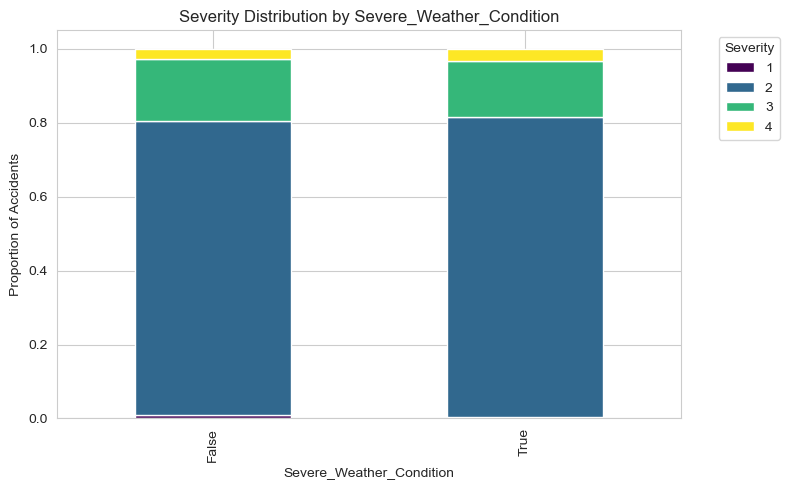

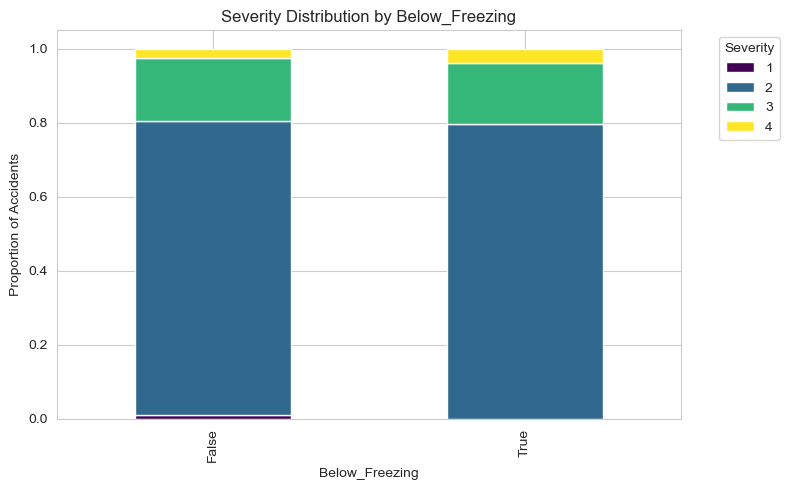

In [59]:
# Explore binary environmental factors by severity
# Set plot style
sns.set_style("whitegrid")

# Define function to create stacked bar chart
def plot_severity_distribution_by_condition(column_name, df):
    severity_counts = df.groupby([column_name, 'Severity']).size().unstack().fillna(0)
    severity_props = severity_counts.div(severity_counts.sum(axis=1), axis=0)  # convert to percentages

    severity_props.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='viridis')
    plt.title(f'Severity Distribution by {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Proportion of Accidents')
    plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot for each binary column
plot_severity_distribution_by_condition('Severe_Weather_Condition', df)
plot_severity_distribution_by_condition('Below_Freezing', df)

### Statistical Analysis

In [60]:
# Run ANOVA test to determine statistical significance of environmental factors increasing accident severity

# Ensure no missing values in relevant columns
df_anova = df[['Severity', 'Visibility(mi)', 'Precipitation(in)', 'Wind_Speed(mph)']].dropna()

# ANOVA for visibility
# Split visibility by severity levels
vis_groups = [df_anova[df_anova['Severity'] == s]['Visibility(mi)'] for s in sorted(df_anova['Severity'].unique())]
f_vis, p_vis = f_oneway(*vis_groups)
print(f"Visibility ANOVA — F = {f_vis:.2f}, p = {p_vis:.4f}")

# ANOVA for precipitation
precip_groups = [df_anova[df_anova['Severity'] == s]['Precipitation(in)'] for s in sorted(df_anova['Severity'].unique())]
f_precip, p_precip = f_oneway(*precip_groups)
print(f"Precipitation ANOVA — F = {f_precip:.2f}, p = {p_precip:.4f}")

# ANOVA for wind speed
wind_groups = [df_anova[df_anova['Severity'] == s]['Wind_Speed(mph)'] for s in sorted(df_anova['Severity'].unique())]
f_wind, p_wind = f_oneway(*wind_groups)
print(f"Wind Speed ANOVA — F = {f_wind:.2f}, p = {p_wind:.4f}")

Visibility ANOVA — F = 2506.21, p = 0.0000
Precipitation ANOVA — F = 1685.09, p = 0.0000
Wind Speed ANOVA — F = 3118.09, p = 0.0000


All three tests returned p-values < 0.0001, indicating strong statistical evidence that these environmental factors are associated with more severe accidents.

In [61]:
# List of binary environmental features to test
env_features = ['Severe_Weather_Condition', 'Below_Freezing']

# Run tests
for feature in env_features:
    print(f"\n{feature}")

    # T-test: Does severity differ significantly?
    group_true = df[df[feature] == True]['Severity']
    group_false = df[df[feature] == False]['Severity']
    t_stat, t_p = ttest_ind(group_true, group_false, equal_var=False)
    print(f"T-test (Severity): t-statistic = {t_stat:.4f}, p-value = {t_p:.6f}")

    # Chi-squared test: Is accident presence more likely under condition?
    contingency_table = df[feature].value_counts().reindex([True, False]).fillna(0).to_frame(name='Count')
    contingency_table['Not_Accident'] = df.shape[0] - contingency_table['Count']
    chi2, chi_p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-squared (Frequency): chi2 = {chi2:.4f}, p-value = {chi_p:.6f}")


Severe_Weather_Condition
T-test (Severity): t-statistic = 0.8500, p-value = 0.395342
Chi-squared (Frequency): chi2 = 13054902.1394, p-value = 0.000000

Below_Freezing
T-test (Severity): t-statistic = 43.8791, p-value = 0.000000
Chi-squared (Frequency): chi2 = 11416345.5692, p-value = 0.000000


- Severe weather = more accidents, same severity
- Freezing temperatures = more accidents, more severe (interesting given our boxplot spread earlier)

Next I want to see if we can identify thresholds where these environmental factors lead to more severe accidents. 

In [62]:
# Create a decision tree
# Transform Severity into a binary target
df['Severe'] = df['Severity'].apply(lambda x: 1 if x >= 3 else 0)

# fit a shallow decision tree
features = ['Visibility(mi)', 'Precipitation(in)', 'Wind_Speed(mph)', 
            'Severe_Weather_Condition', 'Below_Freezing']
X = df[features]
y = df['Severe']

tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=500)
tree.fit(X, y)

# Visualize or extract thresholds
from sklearn.tree import export_text
print(export_text(tree, feature_names=features))


|--- Precipitation(in) <= 0.04
|   |--- Precipitation(in) <= 0.00
|   |   |--- Wind_Speed(mph) <= 3.25
|   |   |   |--- Visibility(mi) <= 27.50
|   |   |   |   |--- Severe_Weather_Condition <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Severe_Weather_Condition >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Visibility(mi) >  27.50
|   |   |   |   |--- class: 0
|   |   |--- Wind_Speed(mph) >  3.25
|   |   |   |--- Wind_Speed(mph) <= 4.80
|   |   |   |   |--- Below_Freezing <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Below_Freezing >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Wind_Speed(mph) >  4.80
|   |   |   |   |--- Wind_Speed(mph) <= 8.05
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Wind_Speed(mph) >  8.05
|   |   |   |   |   |--- class: 0
|   |--- Precipitation(in) >  0.00
|   |   |--- Wind_Speed(mph) <= 3.25
|   |   |   |--- Below_Freezing <= 0.50
|   |   |   |   |--- Visibility(mi) <= 0.88
|   |   |   |   |   

Not super strong results here, but enough to establish some thresholds:
- Precipitation (in): > 0.04, primary risk trigger for increased severity
- Wind Speed (mph): > 3.25 (with rain), heightens risk during moderate precipitation
- Visibility (mi): ≤ 1.05 (with both), highest caution level if all three conditions
- Below_Freezing: matters only when wind speed or precipitation crosses certain thresholds.
- Severe_Weather_Condition: is considered only when visibility and wind are low, which makes intuitive sense, it compounds the risk rather than triggers it alone.

Let's find the probability of severe accidents (levels 3 + 4) under various conditions to see if these findings hold up. 

In [63]:
# Probability estimates
# Prepare Data
features = ['Precipitation(in)', 'Wind_Speed(mph)', 'Visibility(mi)', 'Below_Freezing', 'Severe_Weather_Condition']

# Drop NA values and keep only relevant columns
df_model = df[features + ['Severity']].dropna()

# Convert Severity into binary: 1 = high severity (3 or 4), 0 = low (1 or 2)
df_model['High_Severity'] = df_model['Severity'].apply(lambda x: 1 if x >= 3 else 0)

# Split data into X and y
X = df_model[features]
y = df_model['High_Severity']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state=42)
clf.fit(X_train, y_train)

# Generate Feature Combinations
precip_range = [0.00, 0.02, 0.04, 0.06, 0.10, 0.20]
wind_range = [0, 2, 4, 6, 8, 10]
visibility_range = [0.5, 1.0, 2.0, 5.0, 10.0]
below_freezing_vals = [False, True]
severe_weather_vals = [False, True]

combinations = list(product(precip_range, wind_range, visibility_range, below_freezing_vals, severe_weather_vals))
X_scenarios = pd.DataFrame(combinations, columns=features)

# Predict Probabilities
probas = clf.predict_proba(X_scenarios)
X_scenarios['Probability_Severe'] = probas[:, 1]

# Filter for High-Risk Scenarios
high_risk = X_scenarios[X_scenarios['Probability_Severe'] >= 0.05]

# View top rows of high-risk combinations
print(high_risk.sort_values(by='Probability_Severe', ascending=False).head(15))


     Precipitation(in)  Wind_Speed(mph)  Visibility(mi)  Below_Freezing  \
529                0.1                4             2.0           False   
648                0.2                4             2.0           False   
641                0.2                4             0.5           False   
642                0.2                4             0.5            True   
643                0.2                4             0.5            True   
644                0.2                4             1.0           False   
645                0.2                4             1.0           False   
646                0.2                4             1.0            True   
647                0.2                4             1.0            True   
649                0.2                4             2.0           False   
520                0.1                4             0.5           False   
650                0.2                4             2.0            True   
652                0.2   

- High-Risk Combinations: The model consistently predicts a relatively high probability (~44.7%) of a severe accident under a narrow set of conditions:
    - Precipitation around 0.1–0.2 inches
    - Wind speeds at 4 mph
    - Visibility between 0.5 and 5 miles
    - With or without below freezing temps or severe weather, the model still flags these conditions as risk-prone.
- Feature Impact:
    - The consistent prediction across all combinations of Below_Freezing and Severe_Weather_Condition suggests that these binary factors may not add much separation in the current decision tree.
    - The environmental thresholds (precipitation ~0.2 in, visibility ≤2 mi, wind ~4 mph) seem to be stronger drivers of severity than binary flags.

##### Key Takeaways for Environmental Factors

- DOT should consider issuing heightened alerts or road condition warnings when precipitation surpasses 0.04", especially beyond 0.1".
- DOT could monitor wind speeds exceeding 4 mph in tandem with other factors to prioritize early warnings or road treatment.
- Visibility < 2 miles may act as a risk multiplier, so DOT should track it in conjunction with other triggers.
- Below freezing and severe weather do matter, but only as add-ons to already risky weather 

## Business Insight/Recommendation 3

Infrastructure Considerations: One possible avenue is to identify specific road features associated with accident severity. This might include road design, signage, lighting, or other infrastructural elements that could contribute to or mitigate accident risk.

### Data Exploration

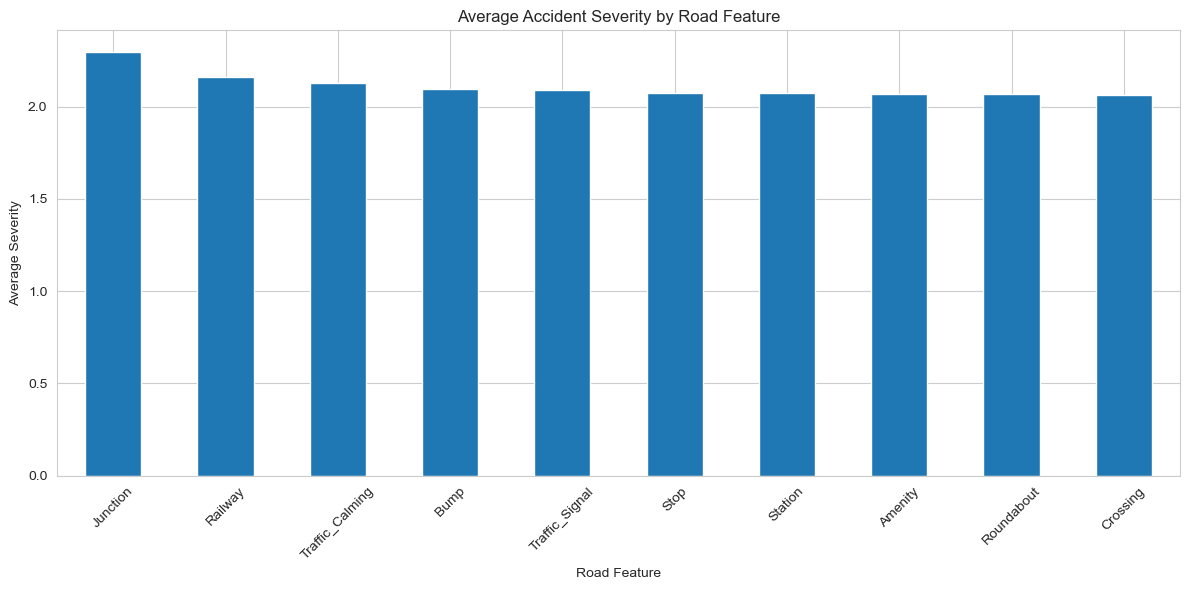

In [64]:
# Average Severity by Road Feature 
infra_features = [
    'Junction', 'Traffic_Signal', 'Stop', 'Crossing',
    'Roundabout', 'Traffic_Calming', 'Bump', 'Railway',
    'Station', 'Amenity'
]

# Compute average severity for each feature
severity_infra = {feature: df[df[feature] == True]['Severity'].mean() for feature in infra_features}

# Plot
plt.figure(figsize=(12, 6))
pd.Series(severity_infra).sort_values(ascending=False).plot(kind='bar')
plt.title('Average Accident Severity by Road Feature')
plt.ylabel('Average Severity')
plt.xlabel('Road Feature')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


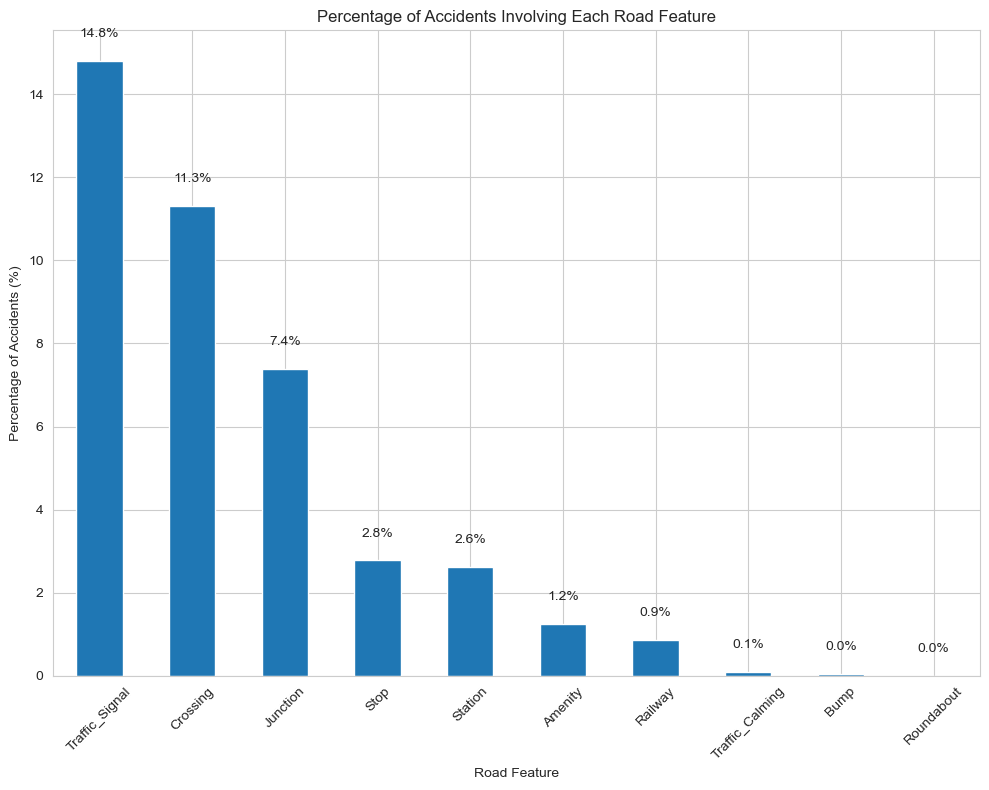

In [65]:
# Percentage of accidents involving each feature
feature_counts = {feature: df[feature].mean() * 100 for feature in infra_features}
feature_series = pd.Series(feature_counts).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 8))
ax = feature_series.plot(kind='bar')
plt.title('Percentage of Accidents Involving Each Road Feature')
plt.ylabel('Percentage of Accidents (%)')
plt.xlabel('Road Feature')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

# Add value labels
for i, v in enumerate(feature_series.values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


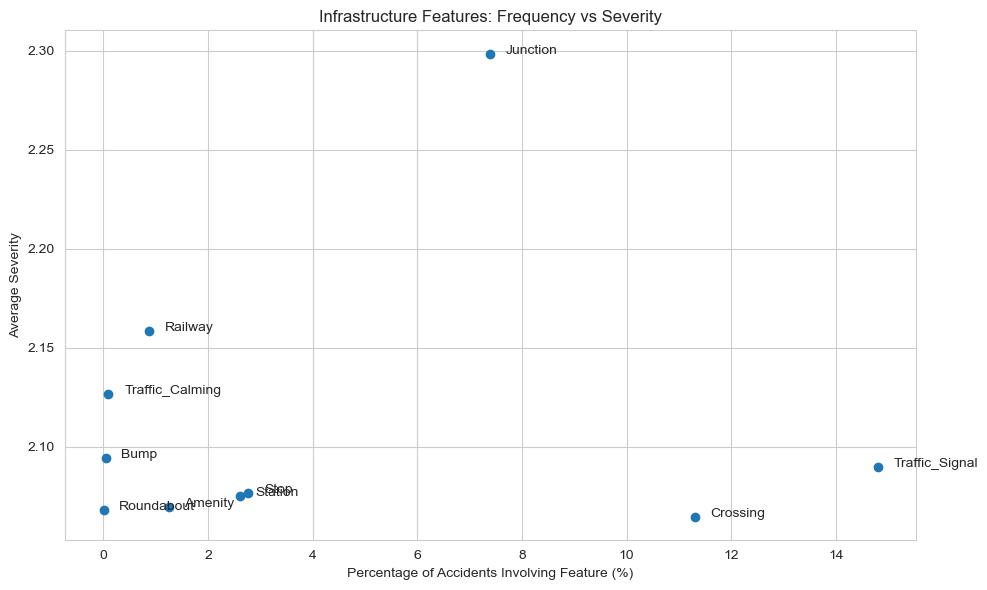

In [66]:
# Scatter Plot: Frequency vs Severity
# Create DataFrame for scatter plot
infra_df = pd.DataFrame({
    'Feature': infra_features,
    'Avg_Severity': [df[df[feature] == True]['Severity'].mean() for feature in infra_features],
    'Accident_Pct': [df[feature].mean() * 100 for feature in infra_features]
})

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(infra_df['Accident_Pct'], infra_df['Avg_Severity'])

# Add labels
for i in range(len(infra_df)):
    plt.text(infra_df['Accident_Pct'][i] + 0.3, infra_df['Avg_Severity'][i], infra_df['Feature'][i])

plt.xlabel('Percentage of Accidents Involving Feature (%)')
plt.ylabel('Average Severity')
plt.title('Infrastructure Features: Frequency vs Severity')
plt.grid(True)
plt.tight_layout()
plt.show()


### Statistical Analysis

In [67]:
from scipy.stats import ttest_ind, chi2_contingency
import pandas as pd

infra_features = ['Junction', 'Traffic_Signal', 'Stop', 'Crossing', 'Roundabout',
                  'Traffic_Calming', 'Bump', 'Railway', 'Station', 'Amenity']

# Initialize results list
results = []

for feature in infra_features:
    # Drop missing values for this feature and severity
    df_feat = df[[feature, 'Severity']].dropna()

    # Chi-Square Test — frequency of accidents at vs. not at location
    counts = df_feat[feature].value_counts()
    contingency_table = [[counts.get(True, 0), counts.get(False, 0)]]
    # Expected under null: equal chance of accident with/without feature
    chi2, p_chi, _, _ = chi2_contingency([contingency_table[0], contingency_table[0]])

    # T-Test — difference in severity
    sev_present = df_feat[df_feat[feature] == True]['Severity']
    sev_absent = df_feat[df_feat[feature] == False]['Severity']
    t_stat, p_ttest = ttest_ind(sev_present, sev_absent, equal_var=False)

    # Store result
    results.append({
        'Feature': feature,
        'Accident Likelihood p-value (Chi2)': p_chi,
        'Severity Difference p-value (t-test)': p_ttest,
        'Mean Severity (Present)': sev_present.mean(),
        'Mean Severity (Absent)': sev_absent.mean()
    })

# Convert to DataFrame for display
infra_results = pd.DataFrame(results)
infra_results.sort_values('Severity Difference p-value (t-test)', inplace=True)

print(infra_results)



           Feature  Accident Likelihood p-value (Chi2)  \
0         Junction                                 1.0   
1   Traffic_Signal                                 1.0   
2             Stop                                 1.0   
3         Crossing                                 1.0   
8          Station                                 1.0   
9          Amenity                                 1.0   
7          Railway                                 1.0   
6             Bump                                 1.0   
5  Traffic_Calming                                 1.0   
4       Roundabout                                 1.0   

   Severity Difference p-value (t-test)  Mean Severity (Present)  \
0                          0.000000e+00                 2.298471   
1                          0.000000e+00                 2.089675   
2                          0.000000e+00                 2.076419   
3                          0.000000e+00                 2.064467   
8                    

- Chi-squared: All results are 1.0, so accidents are not statistically more or less likely to occur at any feature.
- Mean severity where a feature was/wasn't present does show were more severe accidents are likely:
    - Junctions (2.21 -> 2.30)
    - Railways (2.16 -> 2.21)
- Interestingly, pedestrian crossings (Crossings) have the least severe accidents (2.23 -> 2.06)

##### Key Takeaways from Infrastructure Analysis

- Junctions and Railways are associated with higher severity, may benefit from enhanced signage, lighting, or speed control enforcement.
- Traffic control features (signals, stops, roundabouts, crossings) correlate with lower severity, suggesting that these measures may be effective at mitigating impact.
- Traffic calming measures like bumps and calming zones also seem to have a modest protective effect.
- While not statistically significant, roundabouts make up a much smaller percentage of total accidents (<0.0%) than traffic signals (14.8%). Replacing traffic signals with roundabouts may decrease accidents by keeping traffic moving. 

In [68]:
# df.to_csv('us_accidents_cleaned_new.csv', index=False)

### Tableau Dashboard
https://public.tableau.com/app/profile/austin.mohn/viz/USTrafficAccidentAnalysis_17489893136510/Home

## Conclusion and Next Steps
Throughout this project, we looked at over 7.7 million traffic accidents across the United States to understand when and where they happen, what might be causing them, and how serious they are. We uncovered clear patterns related to time of day, day of the week, location, weather conditions, and road features that can help guide better decisions around road safety.

Starting with timing, we found that accidents are most common during weekday rush hours. But even though there are more accidents during those times, they tend to be less severe. On the other hand, accidents on weekends, especially on Saturdays and Sundays, tend to be more serious. Our statistical tests confirmed that these differences are meaningful, not just random. We also saw that severity goes up at night and in the early morning, even though there are fewer accidents during those hours.

When it comes to location, we found big differences depending on the region and state. The South and West see the highest number of accidents overall. But when we looked at severity, states like Georgia, Wisconsin, and Kentucky stood out with the highest averages. Meanwhile, places like North Dakota, Montana, and Oklahoma had the lowest. These results suggest that some states might need more targeted efforts to manage accident risk and improve outcomes.

Weather also plays a big role. Our analysis showed that poor visibility, higher precipitation, and stronger wind speeds are all linked to more serious accidents. In fact, we identified specific tipping points where severity tends to increase. When visibility drops below one mile, precipitation is higher than about 0.04 inches, or wind speeds go above just over three miles per hour, accidents are more likely to be worse. These thresholds could be used to trigger alerts or safety measures during bad weather.

Finally, we looked at the design of the roads themselves. While infrastructure features like traffic lights, roundabouts, and pedestrian crossings didn’t seem to cause more accidents, they were linked to lower severity when accidents did happen. On the flip side, areas like junctions and railway crossings saw more serious crashes. That means adding or improving traffic control features could be a smart way to reduce the harm caused when accidents occur. 

Based on these findings, there are several data-backed strategies the Department of Transportation can put into action to improve road safety. First, the DOT should invest in expanding traffic-calming infrastructure, such as roundabouts, stop signs, and traffic signals, especially in areas near high-severity crash zones like junctions or rail crossings. These features were associated with lower accident severity and can help reduce impact when accidents do occur. Within these options, consider roundabouts where applicable, as they contributed to the least number of accidents, likely due to the continuous nature of their driving pattern and lack of cross-traffic interaction.

Second, the DOT could develop a real-time weather alert system that uses the identified environmental thresholds. For example, they could send driver alerts or dynamically adjust speed limits when visibility drops below one mile or precipitation exceeds 0.04 inches. Partnering with common navigation apps like Google Maps and Apple Maps could help effectively notify drivers in real-time when conditions reach potentionally dangerous conditions. These proactive steps could help prevent more serious accidents during poor weather conditions. 

Third, educational campaigns and enforcement efforts could be timed to target high-risk periods, like weekends and nighttime hours, when accidents are more severe. This could include public messaging, increased patrols, or lighting improvements in areas with frequent nighttime crashes. Together, these strategies provide a well-rounded approach to reducing both the number and severity of traffic accidents across the country.

